# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is loaded from [this url]( https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv). We provide you the code to read the csv from an url. 

## 02 - Load Data
Let's start by loading the time series of the challenge

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("data/monthly_champagne_sales.csv")

👉 Convert dataframe with datetime objects as index to make it look like this
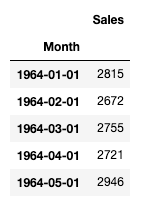

In [0]:
df["Month"] = pd.to_datetime(df["Month"], infer_datetime_format=True)
df.reset_index()
df = df.set_index(df["Month"])
df = df.drop("Month", axis=1)
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


### Alternative - let pandas do the work

In [0]:
# We can also use pandas magic to handle the conversions from the start
df = pd.read_csv("data/monthly_champagne_sales.csv", parse_dates=['Month'], index_col='Month')

## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

<AxesSubplot:xlabel='Month'>

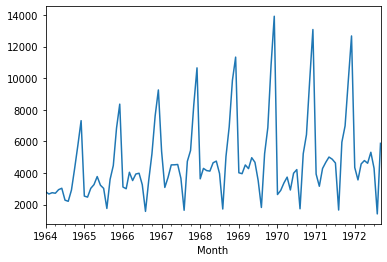

In [0]:
df["Sales"].plot()

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_add = seasonal_decompose(df["Sales"], model="additive")
decomp_mult = seasonal_decompose(df["Sales"], model="multiplicative")

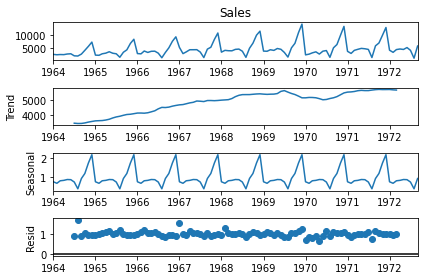

In [0]:
decomp_mult.plot();

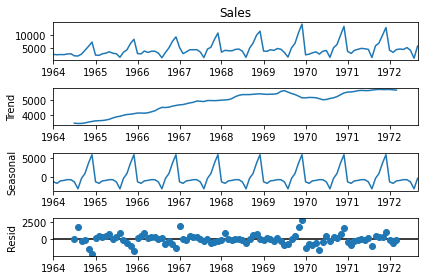

In [0]:
decomp_add.plot();

👉 De-seasonalize this time serie using the decomposition of your choice

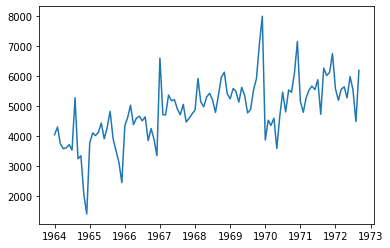

In [0]:
plt.plot(df.Sales - decomp_add.seasonal)

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [0]:
df_train = df[:'1969']
df_test = df['1970':]
print(df_train.shape)
print(df_test.shape)

(72, 1)
(33, 1)


In [0]:
print("train shape: {}, test shape: {}".format(df_train.shape,df_test.shape))

train shape: (72, 1), test shape: (33, 1)


## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [0]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(df_train["Sales"])[1])

p-value:  0.7753855460224308


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

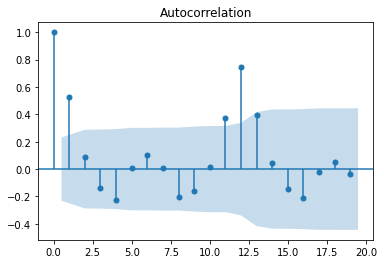

In [0]:
y = df_train.Sales
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

p-value:  2.647350636254994e-09


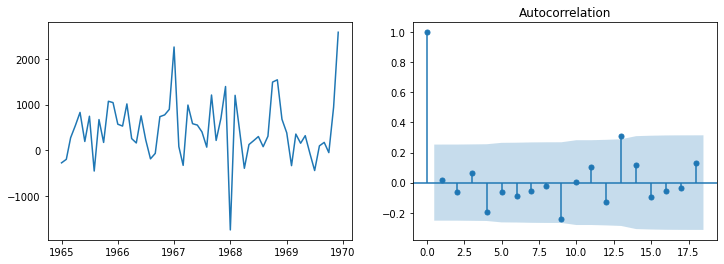

In [0]:
y_diff_12 = df_train.Sales.diff(12).dropna()
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(y_diff_12)
plot_acf(y_diff_12, ax=axes[1])
print('p-value: ', adfuller(y_diff_12)[1])

☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

p-value:  0.0005183923752540804


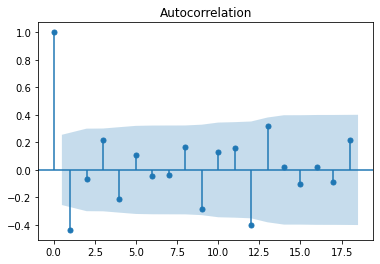

In [0]:
plot_acf(y_diff_12.diff(1).dropna());
print('p-value: ', adfuller(y_diff_12.diff(1).dropna())[1])

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

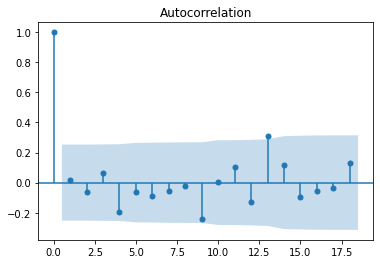

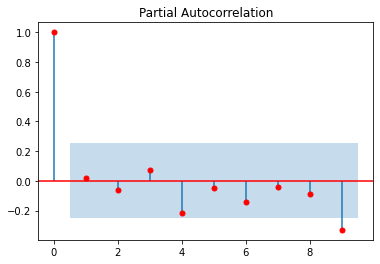

In [0]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y_diff_12);
plot_pacf(y_diff_12, lags=np.arange(10), c='red');

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [0]:
import pmdarima as pm

In [0]:
model = pm.auto_arima(df_train['Sales'],
                      m=12, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.09 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.539 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood 

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [0]:
# Forecast
n_periods = len(df_test)
central, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

👇 Run the cell below to plot your predictions against reality

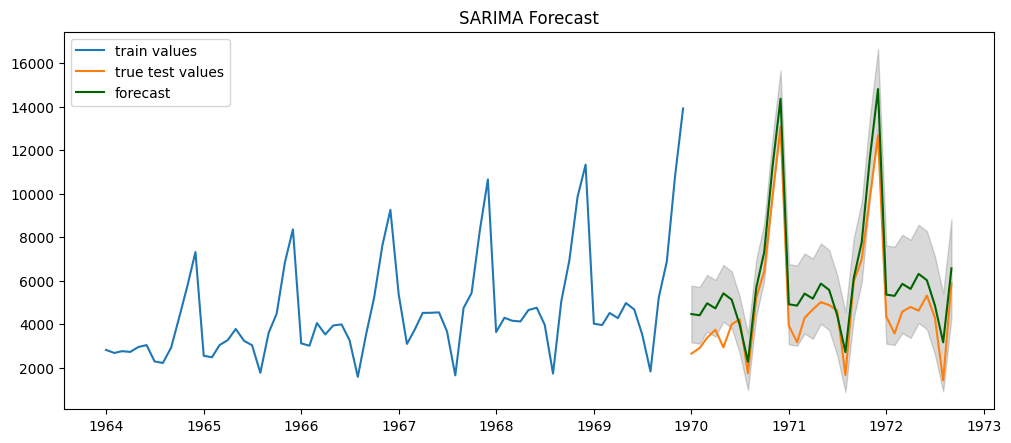

In [0]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

# OPTIONAL - Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [0]:
# Add lagged values
df2 = df.copy()
df2["x_1"] = df["Sales"].shift(1)
df2["x_2"] = df["Sales"].shift(2)
df2["x_3"] = df["Sales"].shift(3)
df2["x_4"] = df["Sales"].shift(4)
df2["x_5"] = df["Sales"].shift(5)
df2["x_6"] = df["Sales"].shift(6)
df2["x_7"] = df["Sales"].shift(7)
df2["x_8"] = df["Sales"].shift(8)
df2["x_9"] = df["Sales"].shift(9)
df2["x_10"] = df["Sales"].shift(10)
df2["x_11"] = df["Sales"].shift(11)
df2["x_12"] = df["Sales"].shift(12)

# Drop nan
df2 = df2.dropna()

# create df_train and df_test 
df2_train = df2[:'1969']
df2_test = df2['1970':]

In [0]:
# Keep track of test_indexes
test_indexes = np.arange(len(df2_train), len(df2_train)+len(df2_test))
test_indexes

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92])

In [0]:
# Create X, y
y = df2['Sales']
X = df2.drop(columns=['Sales'])

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

In [0]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=20, random_state=0)

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [0]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [0]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [0]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.16347530372802851

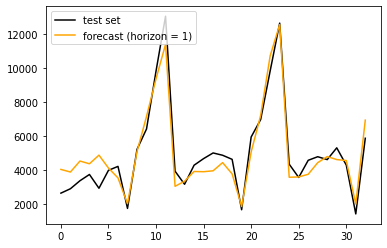

In [0]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [0]:
# Extract the trend using a well chosen moving average
df2['ma_12'] = df2['Sales'].rolling(window=12).mean()
df2['ma_3'] = df2['Sales'].rolling(window=3).mean()
df2['ma_2'] = df2['Sales'].rolling(window=2).mean()

<AxesSubplot:xlabel='Month'>

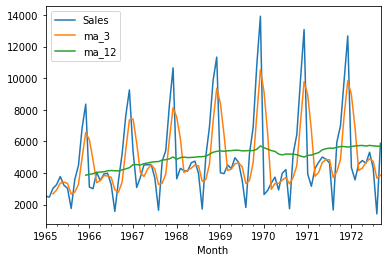

In [0]:
df2[["Sales","ma_3", "ma_12"]].plot()

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

In [0]:
df2["ewma_2"] = df2["Sales"].ewm(halflife=2).mean()
df2["ewma_3"] = df2["Sales"].ewm(halflife=3).mean()
df2["ewma_12"] = df2["Sales"].ewm(halflife=12).mean()

<AxesSubplot:xlabel='Month'>

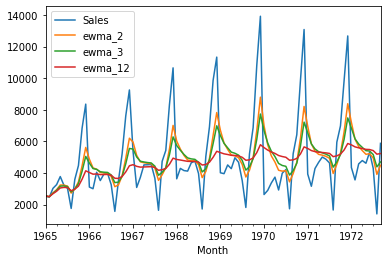

In [0]:
df2[["Sales", "ewma_2", "ewma_3", "ewma_12"]].plot()

In [0]:
random_forest = RandomForestRegressor(n_estimators=20, random_state=12)
features = ["ewma_2", "ewma_3", "ewma_12", "ma_2", "ma_3", "ma_12", "x_1","x_2","x_3","x_4","x_5",
                   "x_6","x_7","x_8","x_9","x_10","x_11","x_12"]
new_features = df2[features].fillna(0).values

results = evaluate_performance_month_prediction(df2["Sales"].values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = new_features)


In [0]:
results[2]

0.147890158319115

You should see a better MAPE!

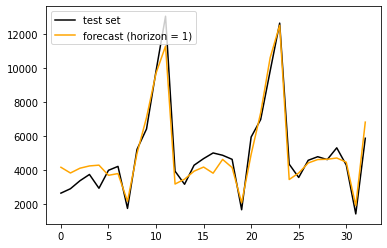

In [0]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

Try to look at the importance of each feature. What do you find?


In [0]:
importances = random_forest.feature_importances_
pd.DataFrame(zip(importances, features)).sort_values(by=0, ascending=False)

,0,1
17,0.821873,x_12
3,0.062603,ma_2
7,0.020262,x_2
16,0.017454,x_11
1,0.014037,ewma_3
4,0.010594,ma_3
8,0.008481,x_3
15,0.007970,x_10
2,0.006503,ewma_12
11,0.005091,x_6


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA